## The Training

### 1st train

Runs with data digit images only.
The best model will be stored as "cnn-s1-md-best.h5"


## The Model

Used a the jomjol CNN-S1 network as small model.



In [1]:
########### Basic Parameters for Running: ################################
    
Training_Percentage = 0.2           
Epoch_Anz = 400                     # earlystopping, see model.fit
nb_classes = 100                     # move to 1. step
#input_shape = (32, 20,1)            # will be calculated
Batch_Size = 8
use_grayscale = False                # grayscale or rgb
output_dir = "output/"
output_tmp_dir = "output/tmp/"
model_filename = "dig-class100-s1"

##########################################################################

from sklearn.model_selection import train_test_split
from b2n.data.tmnist import tmnist_percentals
from b2n.data.ziffer import ziffer_data
from b2n.plotfunctions import *
from sklearn.utils import shuffle
from b2n.encodings.class_encoding import *
from b2n.augmentation.generator import *
from datetime import datetime

date_time = datetime.now().strftime("%Y%m%d-%H%M%S")

#try:
    # Disable all GPUS
#    tf.config.set_visible_devices([], 'GPU')
#    visible_devices = tf.config.get_visible_devices()
#    for device in visible_devices:
#        assert device.device_type != 'GPU'
#except:
    # Invalid device or cannot modify virtual devices once initialized.
#    pass

## Load data

Like the distillation network meter digits will be trained with font builded images.

### digit meter images

The meter digits are all 0-9 ziffer_raw (https://github.com/jomjol/neural-network-autotrain-digital-counter/tree/main/ziffer_raw) and other collected data (used https://github.com/haverland/collectmeterdigits).

### Train and Test data

For 1st train the digit meter will be used.

### digit meter spread

The images of digit meters are collected and labeled by hand. So the image count of labels are differnt. The meter digit spread plot shows the count for each label.

Ziffer data count:  23968
dataset x_train-size=23968


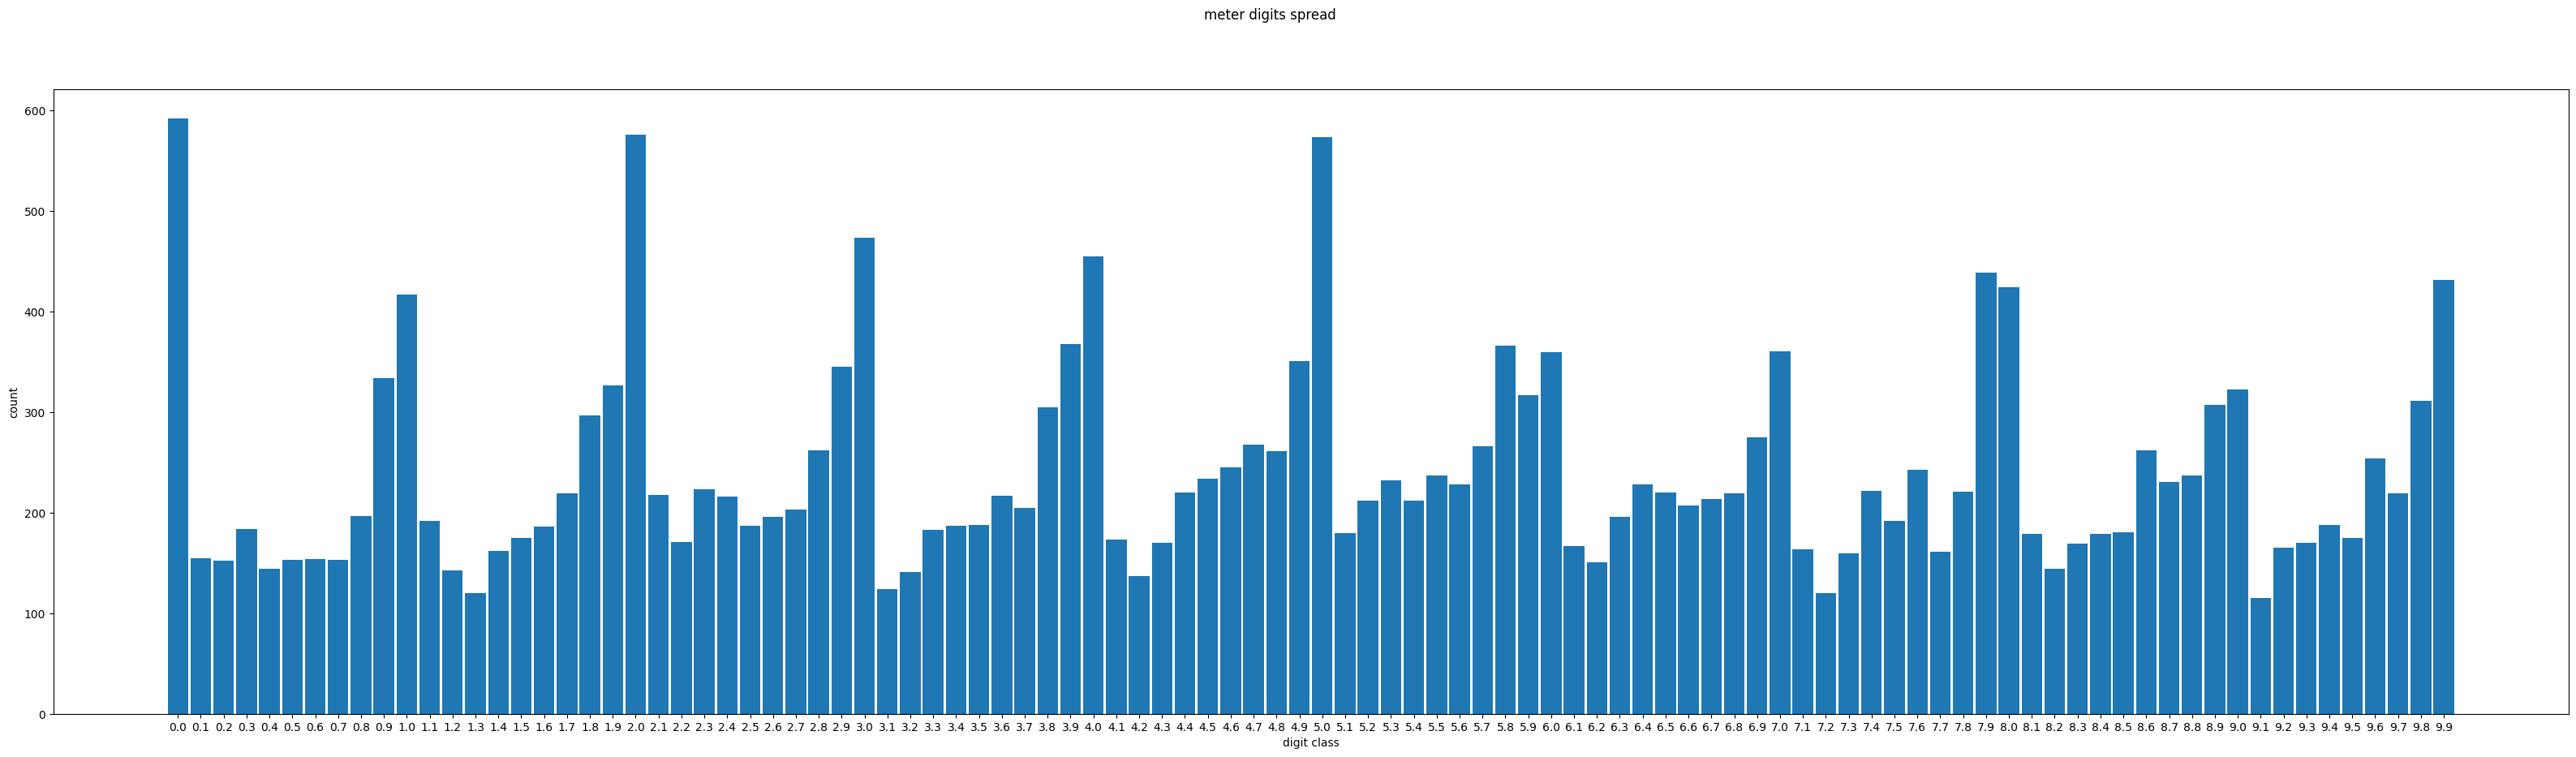

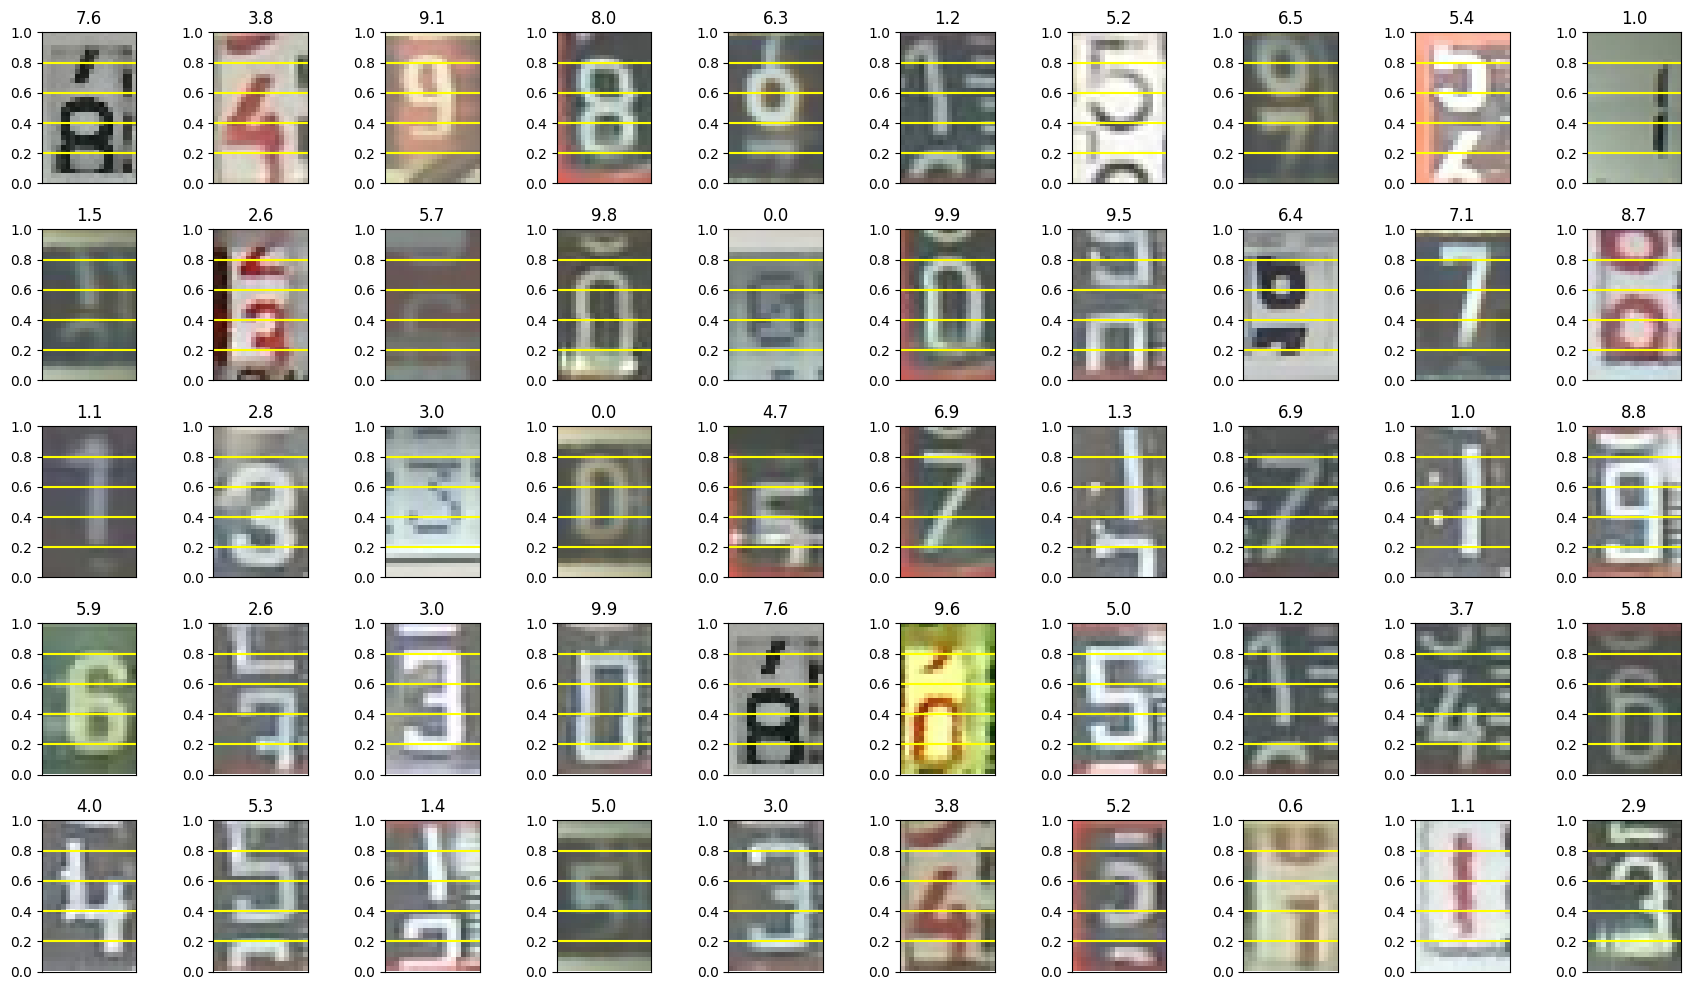

In [2]:


xz_data, yz_data, fz_data = ziffer_data(input_dir='images')

# distribution
_, inverse = np.unique(yz_data, return_inverse=True)
ziffer_bincount = np.bincount(inverse)
plot_divergence(ziffer_bincount, "meter digits spread", nb_classes)


# Split train and validation data 
xz_train, yz_train = shuffle(xz_data, yz_data)
x_train, x_test, y_train, y_test = train_test_split(xz_train, yz_train, test_size=Training_Percentage)

input_shape=xz_train[0].shape
print(f"dataset x_train-size={len(xz_train)}")
plot_dataset(xz_train, yz_train)

y_train = class_encoding(y_train, nb_classes)
y_test = class_encoding(y_test, nb_classes)


### Augmentation
See augementation above for augmentation values.
Standard augmentation of image generator is used plus inverting and noising images.

The validation set is not augmentated. It uses only meter digit images for a real result how the model fits to meter digits.
So the validation says more about the results and its easier to use a early stopping mechanism.

Train data


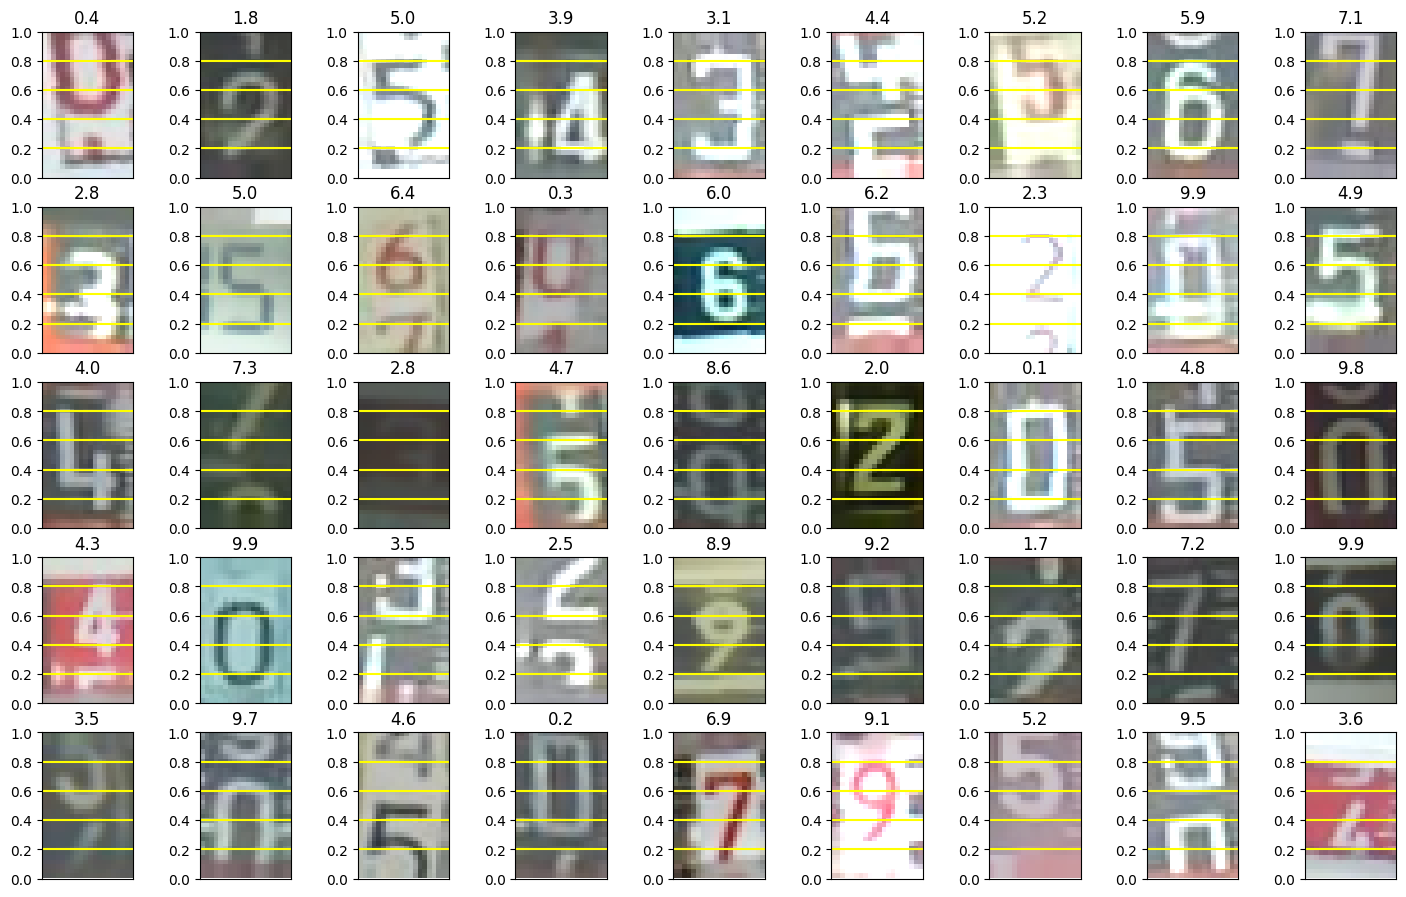

Validation data


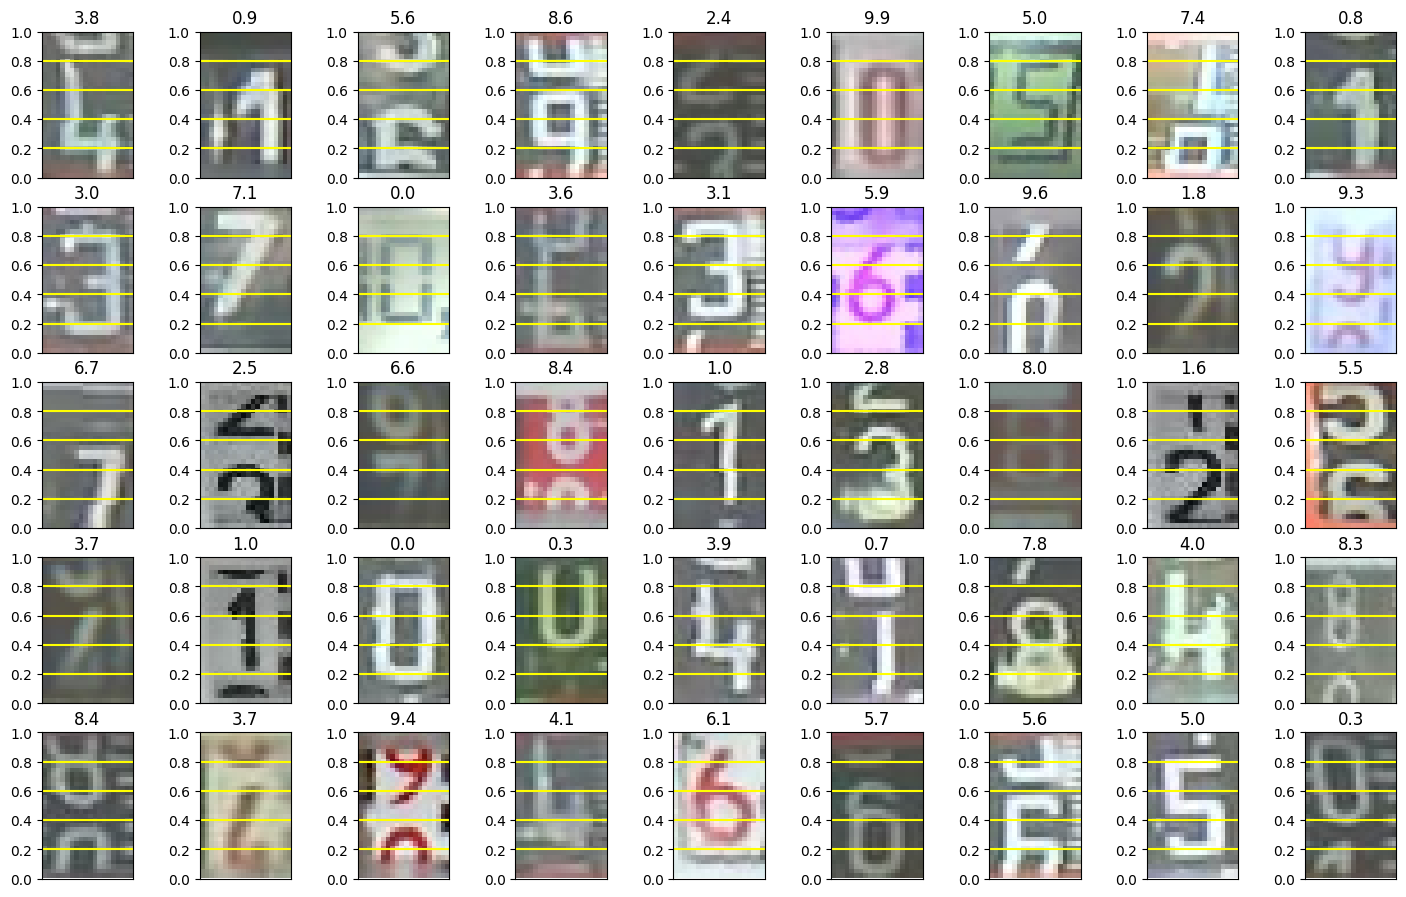

In [3]:
import numpy as np
from b2n.augmentation.generator import augmentation, no_augmentation
from b2n.plotfunctions import plot_dataset_it

train_iterator = augmentation(x_train, y_train, preprocessing_function=None)
validation_iterator = no_augmentation(x_test, y_test)

# train data
print("Train data")
plot_dataset_it(train_iterator)     

# validation data
print("Validation data")
plot_dataset_it(validation_iterator) 


### The Model

Is an small EfficientNet like model with a dense output of 100 at top. 



In [4]:
import tensorflow as tf
from b2n.models.cnn32 import *
from keras import backend as K

#def accuracy(y_true, y_pred):
#    return K.mean(K.less_equal(K.abs((K.abs(K.argmax(y_true))- K.abs(K.argmax(y_pred)))), 1 ))


model = CNN_s1d(input_shape, nb_classes, activation_top=None)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer=tf.optimizers.Adam(learning_rate=1e-3), metrics = ["accuracy"])

C:\Users\Razor\PycharmProjects\PyCharm\venv\lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### The Training

Standard training of the model with complete dataset.

The ModelCheckpoint helps to keep the best model. 

Epoch 1/400


C:\Users\Razor\PycharmProjects\PyCharm\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss did not improve from 0.90000
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.0219 - loss: 5.1461 - val_accuracy: 0.2657 - val_loss: 3.0020 - learning_rate: 0.0010
Epoch 2/400

Epoch 2: val_loss did not improve from 0.90000
600/600 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.2433 - loss: 2.8572 - val_accuracy: 0.6295 - val_loss: 1.0881 - learning_rate: 0.0010
Epoch 3/400

Epoch 3: val_loss improved from 0.90000 to 0.83407, saving model to output/tmp/dig-class100-s1_best.keras
600/600 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.4477 - loss: 1.6968 - val_accuracy: 0.6907 - val_loss: 0.8341 - learning_rate: 0.0010
Epoch 4/400

Epoch 4: val_loss improved from 0.83407 to 0.77899, saving model to output/tmp/dig-class100-s1_best.keras
600/600 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.4954 - loss: 1.4061 - val_accuracy: 0.7005 - val_loss: 0.7790 - learning_rate: 0.0010
Epoch 5/400

Epoch 5: val_loss improved from 0.77899 to 0.69804, saving model to o

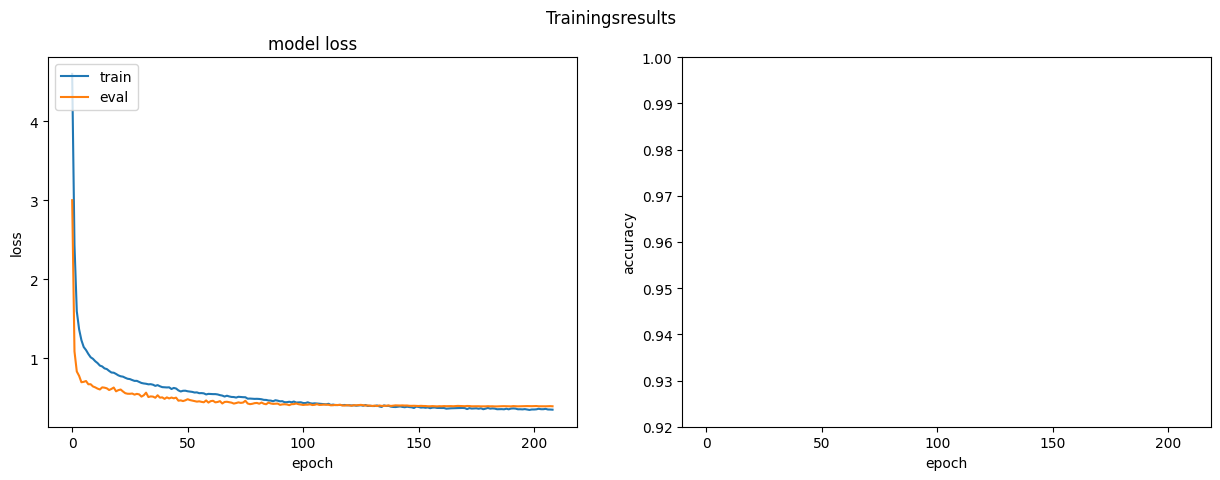

In [5]:
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from b2n.plotfunctions import plot_acc_loss, predict_meter_digits

#annealer = LearningRateScheduler(lambda x: 1e-3 * 0.98 ** x, verbose=0)
earlystop = EarlyStopping(monitor='val_loss', mode='min' , patience=25, verbose=1,  restore_best_weights=True)
mc = ModelCheckpoint(output_tmp_dir + model_filename + '_best.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True, initial_value_threshold=.9)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.85, patience=5, min_lr=1e-5, verbose=1)
history = model.fit(train_iterator, 
                validation_data=validation_iterator, 
                batch_size=Batch_Size, 
                epochs = Epoch_Anz,
                callbacks=[earlystop, mc, reduce_lr],
                verbose=1)


#model.save(model_filename + '.h5')

plot_acc_loss(history, "Trainingsresults")

### Validate on all digit meter

Because of the small dataset of meter digits all meter digits are used for validation. The first false predicted will be shown in the diagram.

749/749 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Tested images: 23968. 39 false predicted. Accuracy is: 0.9983728304405874


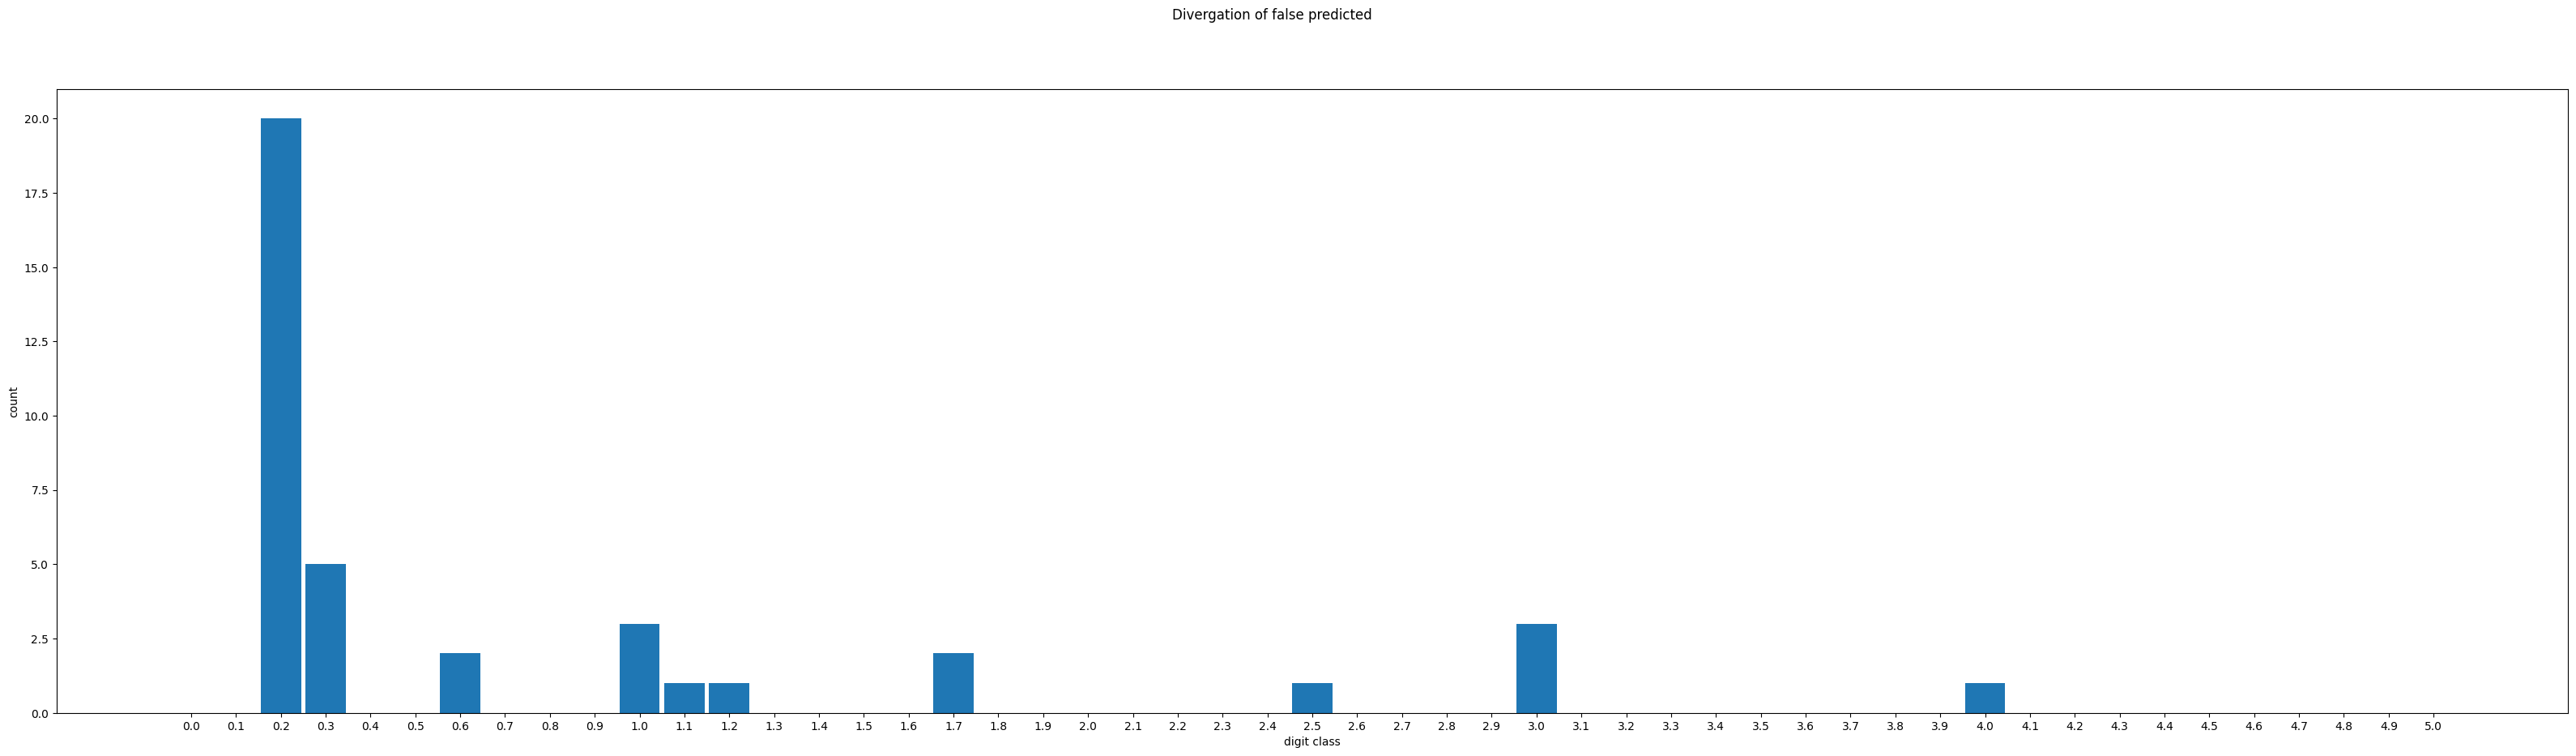

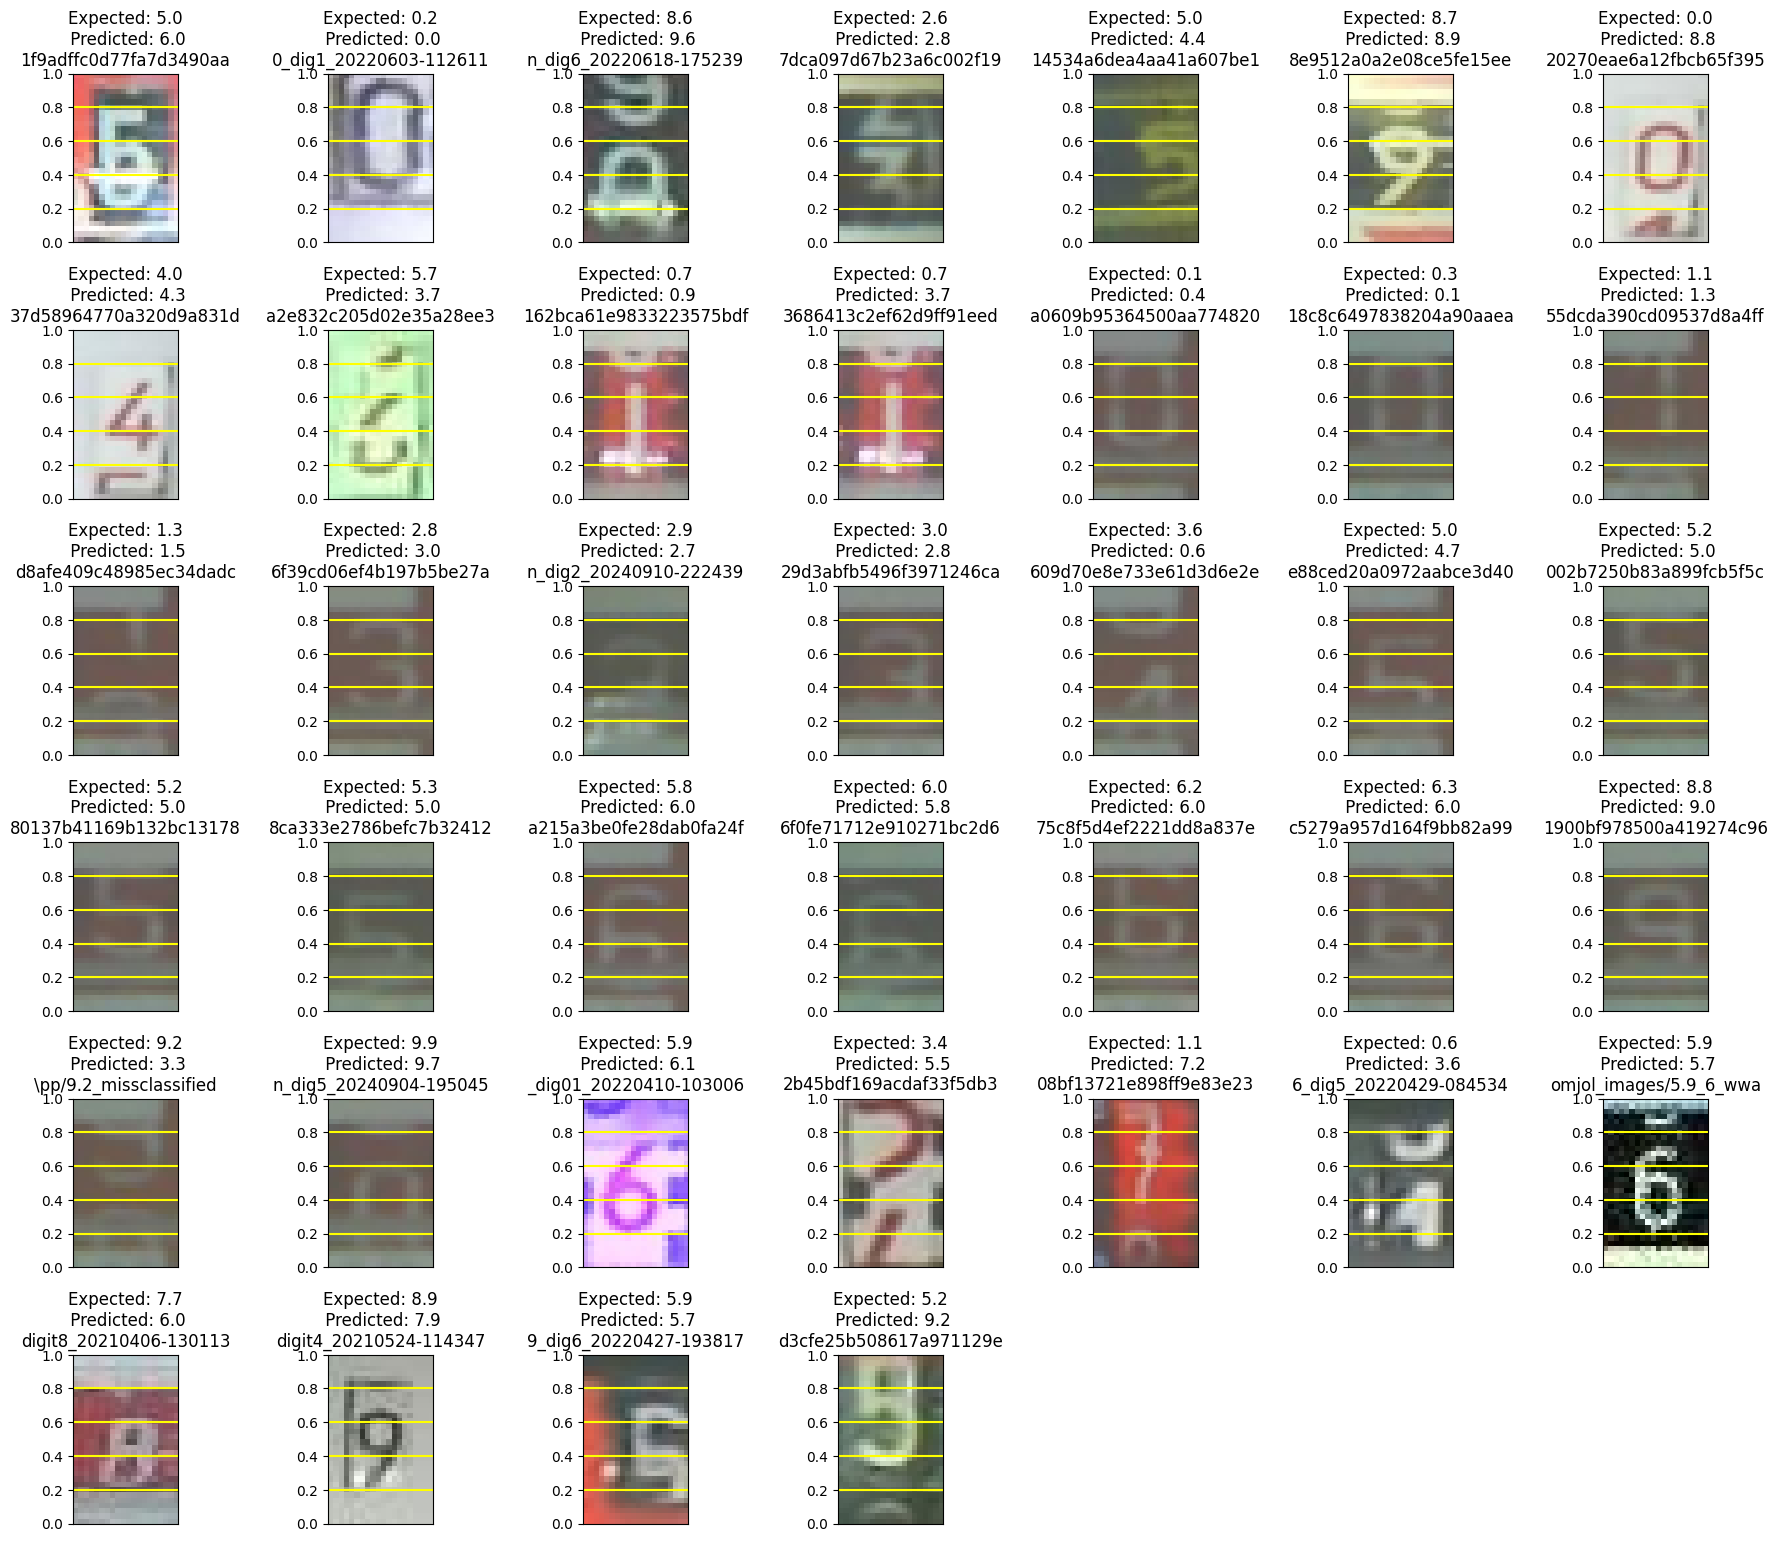

In [7]:
model = keras.models.load_model(output_tmp_dir + model_filename + '_best.keras')
false_predicted_files = predict_meter_digits(model, x_data=xz_data, y_data=yz_data, f_data=fz_data, 
                                            max_delta=0.11)
fpf = pd.DataFrame(false_predicted_files)

# the csv can be used with collectmeterdigits to fix labels
# python3 -m collectmeterdigits --labelfile=output/tmp/dig-class100-s1_false_predicted.csv
fpf.to_csv(output_tmp_dir + model_filename + '_false_predicted.csv')

In [8]:
from b2n.models.prune_quantize import prune, quantization_default
from  tensorflow import keras

# prune the model
model_pruned = model
# pruning reduces the accurracy 
#model_pruned = prune(model=model, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

# quanitize and save the model
tflite_model = quantization_default(model=model_pruned, 
                            x_train=x_test)
# save the model
filename=output_dir + model_filename  + "_" + date_time + "_q.tflite"                                                 
open( filename, "wb").write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\Razor\AppData\Local\Temp\tmpgxg7is3d\assets


INFO:tensorflow:Assets written to: C:\Users\Razor\AppData\Local\Temp\tmpgxg7is3d\assets


Saved artifact at 'C:\Users\Razor\AppData\Local\Temp\tmpgxg7is3d'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 20, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 100), dtype=tf.float32, name=None)
Captures:
  2830769490400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2830769488816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2829080004912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2830769490752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2830781555808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2830786016528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2829081724880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2829081724352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2829855033120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2829855032416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  282908

C:\Users\Razor\PycharmProjects\PyCharm\venv\lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


156488